In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from survshares.datasets import SurvivalDataset
dataset = SurvivalDataset('Rossi')
X, T, E = dataset.load() 
feature_names = dataset.features

In [29]:
from survshares.timegrid_regressor import _TimegridProgram, TimegridRegressor

In [30]:
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
transformer = LabTransDiscreteTime(np.linspace(T.min(), T.max(), 100))
#transformer = LabTransDiscreteTime(np.unique(T).astype(np.float64))
T_idx, E = transformer.transform(T, E)
transformer.cuts.shape

(100,)

In [31]:
from gplearn_clean.gplearn.fitness import mean_square_error
from gplearn_clean.gplearn.functions import add2, sub2, mul2, div2
from sklearn.utils.validation import check_random_state

program_params = {
    "function_set": [add2, sub2, mul2, div2],
    "arities": {2: [add2, sub2, mul2, div2]},
    "init_depth": (2, 6),
    "init_method": "half and half",
    "n_features": 2,
    "const_range": (-1.0, 1.0),
    "metric": mean_square_error,
    "p_point_replace": 0.05,
    "parsimony_coefficient": 0.01,
    "random_state": check_random_state(415),
}

prog = [mul2, 0, 2]
gp = _TimegridProgram(tgrid = transformer.cuts, program=prog, **program_params, ghat=np.array([0.69]))
y_pred = gp.execute(np.array([[1, 2], [2, 2]]))
gp.raw_fitness(X, T_idx, E)

tensor(0.2667)

In [32]:
from gplearn_clean.gplearn.fitness import make_fitness 
loss_fitness = make_fitness(function=lambda x, y, z: 0, greater_is_better=False)

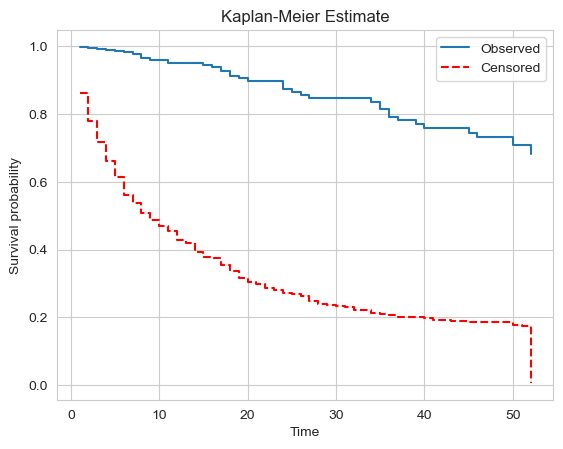

In [33]:
from sksurv.nonparametric import kaplan_meier_estimator

# E is 1 if event occurred, 0 if censored
time, survival_prob = kaplan_meier_estimator(E.astype(bool), T)
time, cens_prob = kaplan_meier_estimator((1-E).astype(bool), T)

plt.step(time, survival_prob, where="post")
plt.step(time, cens_prob, where="post", linestyle="--", color="red")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Kaplan-Meier Estimate")
plt.legend(["Observed", "Censored"])
plt.show()

In [34]:
cens_prob[-1]

np.float64(0.006619706859234364)

In [35]:
from sksurv.util import Surv
from sksurv.nonparametric import CensoringDistributionEstimator
import numpy as np

# Assume y is a structured array with fields ('event', 'time')
# event = 1 if failure, 0 if censored
# Step 1: Create censoring survival object: treat censoring as the event

# Step 2: Fit Kaplan-Meier estimator to censoring distribution
censor_estimator = CensoringDistributionEstimator()
censor_estimator.fit(Surv.from_arrays(event=E, time=T_idx))

CensoringDistributionEstimator()

In [36]:
from sksurv.util import Surv
from sksurv.nonparametric import CensoringDistributionEstimator
import numpy as np

# Assume y is a structured array with fields ('event', 'time')
# event = 1 if failure, 0 if censored
# Step 1: Create censoring survival object: treat censoring as the event

# Step 2: Fit Kaplan-Meier estimator to censoring distribution
censor_estimator = CensoringDistributionEstimator()
censor_estimator.fit(Surv.from_arrays(event=E, time=T_idx))

# Step 3: Compute P(not censored by t_i) = G(t_i) for each subject
G_hat = censor_estimator.predict_proba(np.unique(T_idx))

G_hat

array([0.86078886, 0.77958237, 0.77958237, 0.71675035, 0.71675035,
       0.66071775, 0.66071775, 0.61385834, 0.61385834, 0.56211549,
       0.56211549, 0.53849719, 0.53849719, 0.50765815, 0.50765815,
       0.48841044, 0.48841044, 0.46906746, 0.45456022, 0.45456022,
       0.42767762, 0.42034601, 0.39346341, 0.37880018, 0.37880018,
       0.3738807 , 0.3738807 , 0.35407245, 0.35407245, 0.33624146,
       0.31586319, 0.31586319, 0.30302322, 0.30302322, 0.29784334,
       0.28489363, 0.27971374, 0.27194392, 0.27194392, 0.2692778 ,
       0.2692778 , 0.26389225, 0.26389225, 0.24756901, 0.24756901,
       0.23931671, 0.23656595, 0.23381518, 0.23106441, 0.22281211,
       0.22006135, 0.21180905, 0.21180905, 0.20894676, 0.20608448,
       0.20608448, 0.20019635, 0.20019635, 0.20019635, 0.19716307,
       0.19716307, 0.19100172, 0.18792105, 0.18484038, 0.18484038,
       0.18484038, 0.17846657, 0.17846657, 0.17516164, 0.        ])

In [44]:
model = TimegridRegressor(metric=loss_fitness, program_class=_TimegridProgram, verbose=True, tgrid=transformer.cuts, feature_names=feature_names, generations=10)
model.fit(X, T_idx, E)

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.24           475268        5         0.175809              N/A     23.06s
   1     5.62         0.317852        5         0.175809              N/A     16.32s
   2     6.12         0.271564        9         0.166474              N/A     14.17s
   3     5.62         0.321133        7         0.164464              N/A     12.23s
   4     6.82         0.291149        7         0.162007              N/A     10.19s
   5     7.67         0.252371        7         0.162007              N/A      8.20s
   6     7.07         0.241433        7         0.162007              N/A      6.11s
   7     7.08         0.242731        7         0.162007              N/A      4.08s
   8     6.94         0.260375        7         0.162007              N/A  

TimegridRegressor(feature_names=['fac_fin', 'fac_race', 'fac_wexp', 'fac_mar',
                                 'fac_paro', 'fac_prio', 'fac_educ', 'fac_emp',
                                 'num_age'],
                  generations=10, ghat=array([0.]),
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x16e341810>,
                  tgrid=array([ 1.        ,  1.51515152,  2.03030303,  2.54545455,  3.06060606,
        3.57575758,  4.09090909,  4.60606061,  5.12121212,  5.63636364,
        6.15151...
       37.06060606, 37.57575758, 38.09090909, 38.60606061, 39.12121212,
       39.63636364, 40.15151515, 40.66666667, 41.18181818, 41.6969697 ,
       42.21212121, 42.72727273, 43.24242424, 43.75757576, 44.27272727,
       44.78787879, 45.3030303 , 45.81818182, 46.33333333, 46.84848485,
       47.36363636, 47.87878788, 48.39393939, 48.90909091, 49.42424242,
       49.93939394, 50.45454545, 50.96969697, 51.48484848, 52.        ]),
                  verbose=True)

In [49]:
model.predict_proba(X)[10,].sum()

tensor(0.1483)

In [50]:
from survshares.loss import approximateNpllLoss, npllLoss

survival_params = {
    "function_set": [add2, sub2, mul2, div2],
    "arities": {2: [add2, sub2, mul2, div2]},
    "init_depth": (2, 6),
    "init_method": "half and half",
    "const_range": (-1.0, 1.0),
    "metric": loss_fitness,
    "p_point_replace": 0.05,
    "parsimony_coefficient": 0.1,
    "optim_dict": {
        "alg": "adam",
        "lr": 1e-2,
        "max_n_epochs": 1000,
        "tol": 1e-3,
        "task": "survival",
        "device": "cpu",
        "batch_size": 1000,
        "constructor_dict": {
            "n_hidden_layers": 5,
            "width": 10,
            "activation_name": "ELU",
        },
        "num_workers_dataloader": 0,
        "seed": 42,
        "checkpoint_folder": "results/checkpoints/test",
        "keep_models": False,
        "enable_progress_bar": False,
        "loss_fn": approximateNpllLoss(),
    },
    "random_state": check_random_state(415),
}

In [ ]:
share_gam = lambda n_covs: [add2] * (n_covs - 1) + [node for i in range(n_covs) for node in [shape1, i]]

gp = _TimegridProgram(program=share_gam(X.shape[1]), **survival_params, n_features=X.shape[1])
gp.fit(torch.Tensor(X), torch.Tensor(T), torch.Tensor(E))
y_pred = gp.execute(torch.Tensor(X))